# Path

In [3]:
covid_19_data_path='E:\Big data\covid19 Analysis\Covid-19-Analysis'

# Imports

In [4]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

C:\Users\ROMIL\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# COVID-19 Analysis

In [5]:
covid_19_confirmed_cases=pd.read_csv(covid_19_data_path+'/covid_confirmed_usafacts.csv')
usa_county_population=pd.read_csv(covid_19_data_path+'/covid_county_population_usafacts.csv')
covid_19_deaths=pd.read_csv(covid_19_data_path+'/covid_deaths_usafacts.csv')

In [23]:
covid_19_confirmed_cases.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,23,25,25,25,25,27,28,30,32,33
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,87,98,102,103,109,114,117,123,132,143
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,11,13,14,15,18,20,22,28,29,30
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,17,19,23,23,26,28,32,32,33,33


In [8]:
# fetching all the dates columns
dates=covid_19_confirmed_cases.columns[4:]
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15

# Helper functions

#### Function to count number of confirmed cases or number of death cases per day. It takes arguments a dataframe and dates

In [9]:
def cases_per_day_count(df,dates):
    dict_cases_per_day={}
    day_count=1
    for date in dates:
        dict_cases_per_day[day_count]=df[date].sum()
        day_count+=1
    cases_per_day = pd.DataFrame(list(dict_cases_per_day.items()),columns = ['Day','NumberOfCases'])
    return cases_per_day

#### Function to count number of new confirmed cases. It takes arguments a dataframe.

In [10]:
def new_cases_per_day_count(df_cases_per_day):
    dict_new_cases_per_day={}
    # for the first day
    dict_new_cases_per_day[1]=df_cases_per_day['NumberOfCases'][0]
    curr_day=2
    while curr_day<=len(df_cases_per_day):
        dict_new_cases_per_day[curr_day]=df_cases_per_day['NumberOfCases'][curr_day-1]-df_cases_per_day['NumberOfCases'][curr_day-2]
        curr_day+=1
    new_cases_per_day = pd.DataFrame(list(dict_new_cases_per_day.items()),columns = ['Day','NumberOfNewCases'])
    return new_cases_per_day

#### Function to count number of confirmed cases or number of death cases per week. It takes arguments a dataframe and dates

In [77]:
# Here, we are not considering the last week because it has only 2 days' data available. So, it might give us false impression
def cases_per_week_count(df_cases_per_day,dates):
    dict_cases_per_week={}
    week=0
    curr_day=7
    while curr_day<len(dates):
        week+=1
        dict_cases_per_week[week]=df_cases_per_day['NumberOfCases'][curr_day-1]
        curr_day+=7
    cases_per_week = pd.DataFrame(list(dict_cases_per_week.items()),columns = ['Week','NumberOfCases'])
    return cases_per_week

#### Function to count number of new confirmed cases or number of new deaths cases per week. It takes an argument a dataframe.

In [78]:
def new_cases_per_week_count(df_cases_per_week):
    dict_new_cases_per_week={}
    # for the first week
    dict_new_cases_per_week[1]=df_cases_per_week['NumberOfCases'][0]
    curr_week=2
    while curr_week<=len(df_cases_per_week):
        dict_new_cases_per_week[curr_week]=df_cases_per_week['NumberOfCases'][curr_week-1]-df_cases_per_week['NumberOfCases'][curr_week-2]
        curr_week+=1
    new_cases_per_week = pd.DataFrame(list(dict_new_cases_per_week.items()),columns = ['Week','NumberOfNewCases'])
    return new_cases_per_week

## 1. Total confirmed cases per day in the country.

In [79]:
confirmed_cases_per_day=cases_per_day_count(covid_19_confirmed_cases,dates)
confirmed_cases_per_day

,Day,NumberOfCases
0,1,1
1,2,1
2,3,2
3,4,2
4,5,5
...,...,...
88,89,750224
89,90,776819
90,91,802311
91,92,831126


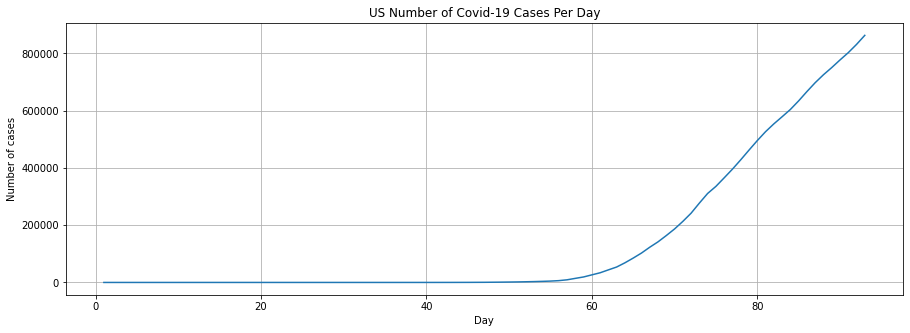

In [80]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.plot(confirmed_cases_per_day['Day'],confirmed_cases_per_day['NumberOfCases'])
plt.grid()
plt.show()

## 2. Total confirmed new cases per day in the country.

In [81]:
new_confirmed_cases_per_day=new_cases_per_day_count(confirmed_cases_per_day)
new_confirmed_cases_per_day

,Day,NumberOfNewCases
0,1,1
1,2,0
2,3,1
3,4,0
4,5,3
...,...,...
88,89,25023
89,90,26595
90,91,25492
91,92,28815


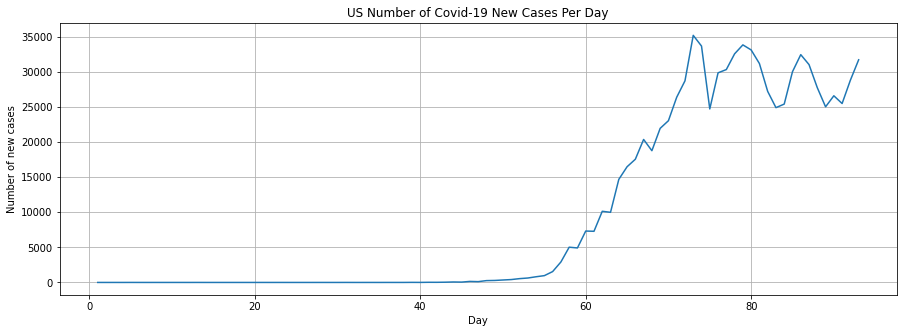

In [82]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of new cases')
plt.plot(new_confirmed_cases_per_day['Day'],new_confirmed_cases_per_day['NumberOfNewCases'])
plt.grid()
plt.show()

## 3. Total confirmed cases per week in the country.

In [83]:
confirmed_cases_per_week=cases_per_week_count(confirmed_cases_per_day,dates)
confirmed_cases_per_week

,Week,NumberOfCases
0,1,6
1,2,11
2,3,12
3,4,14
4,5,18
5,6,81
6,7,1039
7,8,6302
8,9,53898
9,10,186757


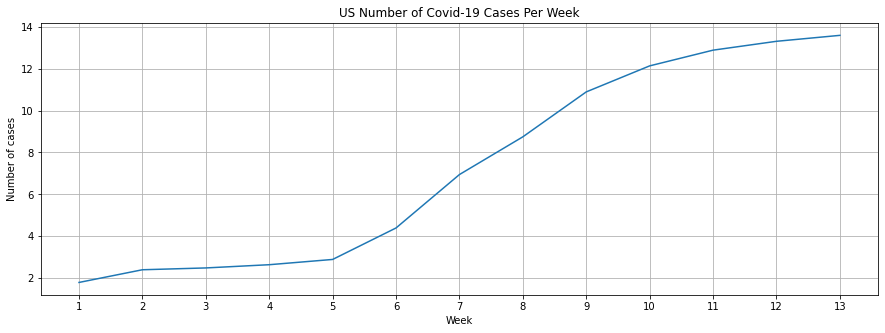

In [85]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Cases Per Week')
plt.xlabel('Week')
plt.ylabel('Number of cases')
plt.xticks(range(1,14))
plt.plot(confirmed_cases_per_week['Week'],np.log(confirmed_cases_per_week['NumberOfCases']))
plt.grid()
plt.show()

## 4. Number of new confirmed cases per week in the the country

In [86]:
new_confirmed_cases_per_week=new_cases_per_week_count(confirmed_cases_per_week)
new_confirmed_cases_per_week

,Week,NumberOfNewCases
0,1,6
1,2,5
2,3,1
3,4,2
4,5,4
5,6,63
6,7,958
7,8,5263
8,9,47596
9,10,132859


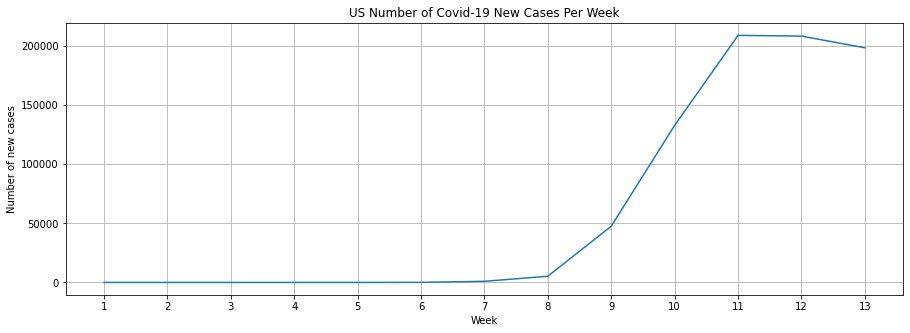

In [87]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Cases Per Week')
plt.xlabel('Week')
plt.ylabel('Number of new cases')
plt.xticks(range(1,14))
plt.plot(new_confirmed_cases_per_week['Week'],(new_confirmed_cases_per_week['NumberOfNewCases']))
plt.grid()
plt.show()

As we can see in the plot 

## 5. Total deaths per day in the country.

In [88]:
deaths_per_day=cases_per_day_count(covid_19_deaths,dates)
deaths_per_day

,Day,NumberOfCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
88,89,35691
89,90,37349
90,91,39783
91,92,41582


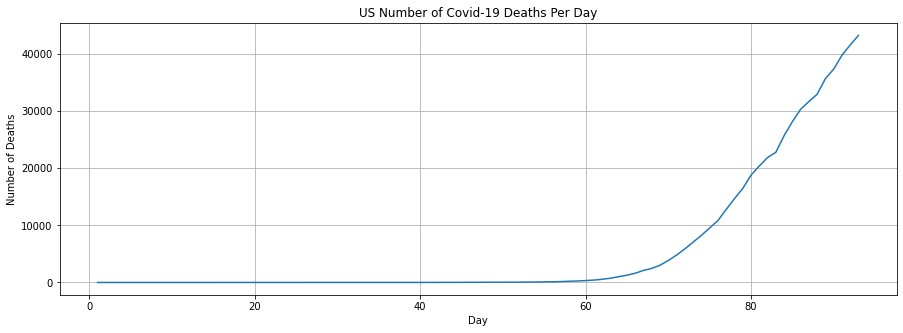

In [89]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Deaths Per Day')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.plot(deaths_per_day['Day'],deaths_per_day['NumberOfCases'])
plt.grid()
plt.show()

## 6. Total new deaths per day in the country.

In [90]:
new_deaths_per_day=new_cases_per_day_count(deaths_per_day)
new_deaths_per_day

,Day,NumberOfNewCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
88,89,2737
89,90,1658
90,91,2434
91,92,1799


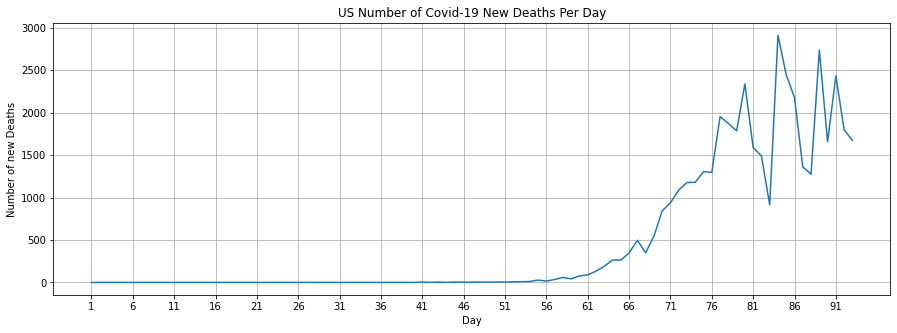

In [91]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Deaths Per Day')
plt.xlabel('Day')
plt.ylabel('Number of new Deaths')
plt.plot(new_deaths_per_day['Day'],new_deaths_per_day['NumberOfNewCases'])
plt.xticks(range(1,95,5))
plt.grid()
plt.show()

## 7. Total deaths per week in the country.

In [96]:
deaths_per_week=cases_per_week_count(death_cases_per_day,dates)
deaths_per_week

,Week,NumberOfCases
0,1,0
1,2,0
2,3,1
3,4,2
4,5,2
5,6,9
6,7,34
7,8,115
8,9,739
9,10,3849


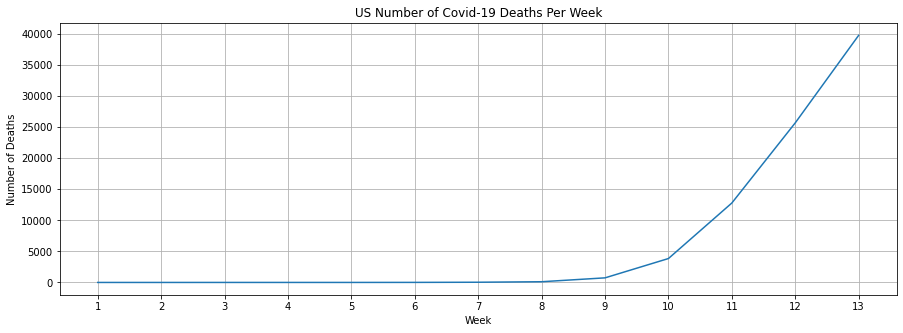

In [97]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 Deaths Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Deaths')
plt.xticks(range(1,15))
plt.plot(deaths_per_week['Week'],(deaths_per_week['NumberOfCases']))
plt.grid()
plt.show()

## 8. Number of New Deaths per week in the the country

In [98]:
new_deaths_per_week=new_cases_per_week_count(deaths_per_week)
new_deaths_per_week

,Week,NumberOfNewCases
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
5,6,7
6,7,25
7,8,81
8,9,624
9,10,3110


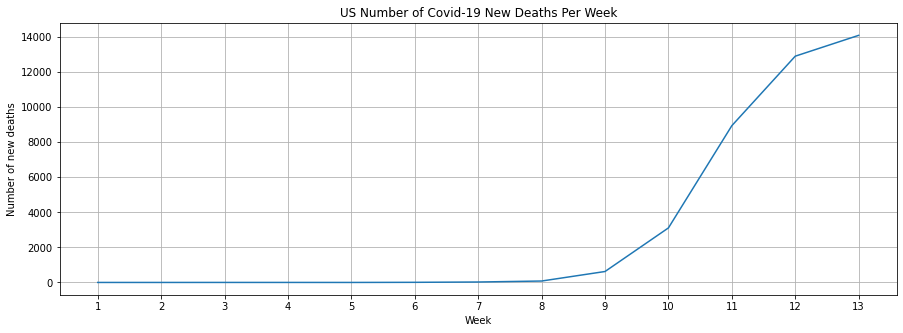

In [99]:
plt.figure(figsize=(15,5))
plt.title('US Number of Covid-19 New Deaths Per Week')
plt.xlabel('Week')
plt.ylabel('Number of new deaths')
plt.xticks(range(1,15))
plt.plot(new_deaths_per_week['Week'],(new_deaths_per_week['NumberOfNewCases']))
plt.grid()
plt.show()

## 9. Top 10 counties with the most known number of covid-19 cases.

In [100]:
sorted_covid_19_confirmed_cases=covid_19_confirmed_cases.sort_values(by='4/23/20',ascending=False)
counties_with_most_known_cases=sorted_covid_19_confirmed_cases.head(10)
counties_with_most_known_cases=counties_with_most_known_cases.reset_index(drop=True)
counties_with_most_known_cases

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,36081,Queens County,NY,36,0,0,0,0,0,0,...,35053,36765,37918,39091,40216,41237,42023,42822,43713,44904
1,36047,Kings County,NY,36,0,0,0,0,0,0,...,29306,31969,33521,34705,35763,36482,37030,37694,38481,39354
2,36059,Nassau County,NY,36,0,0,0,0,0,0,...,25250,26715,27772,28539,29180,30013,30677,31079,31555,32124
3,36005,Bronx County,NY,36,0,0,0,0,0,0,...,23266,24653,25932,27035,28019,28823,29372,30142,31130,31659
4,36103,Suffolk County,NY,36,0,0,0,0,0,0,...,22462,23278,24182,25035,26143,26888,27662,28154,28854,29567
5,36119,Westchester County,NY,36,0,0,0,0,0,0,...,20191,20947,21828,22476,23179,23803,24306,24656,25276,25959
6,17031,Cook County,IL,17,0,0,1,1,1,1,...,16323,17306,18087,19391,20395,21272,22101,23181,24546,25811
7,36061,New York County,NY,36,0,0,0,0,0,0,...,14880,16617,17091,17490,17932,18220,18468,18699,19025,19348
8,6037,Los Angeles County,CA,6,0,0,0,0,1,1,...,10047,10496,10854,11391,12021,12341,13816,15140,16435,17508
9,26163,Wayne County,MI,26,0,0,0,0,0,0,...,12209,12544,13002,13233,13471,13692,13912,14255,14561,14994


### Per week distribution

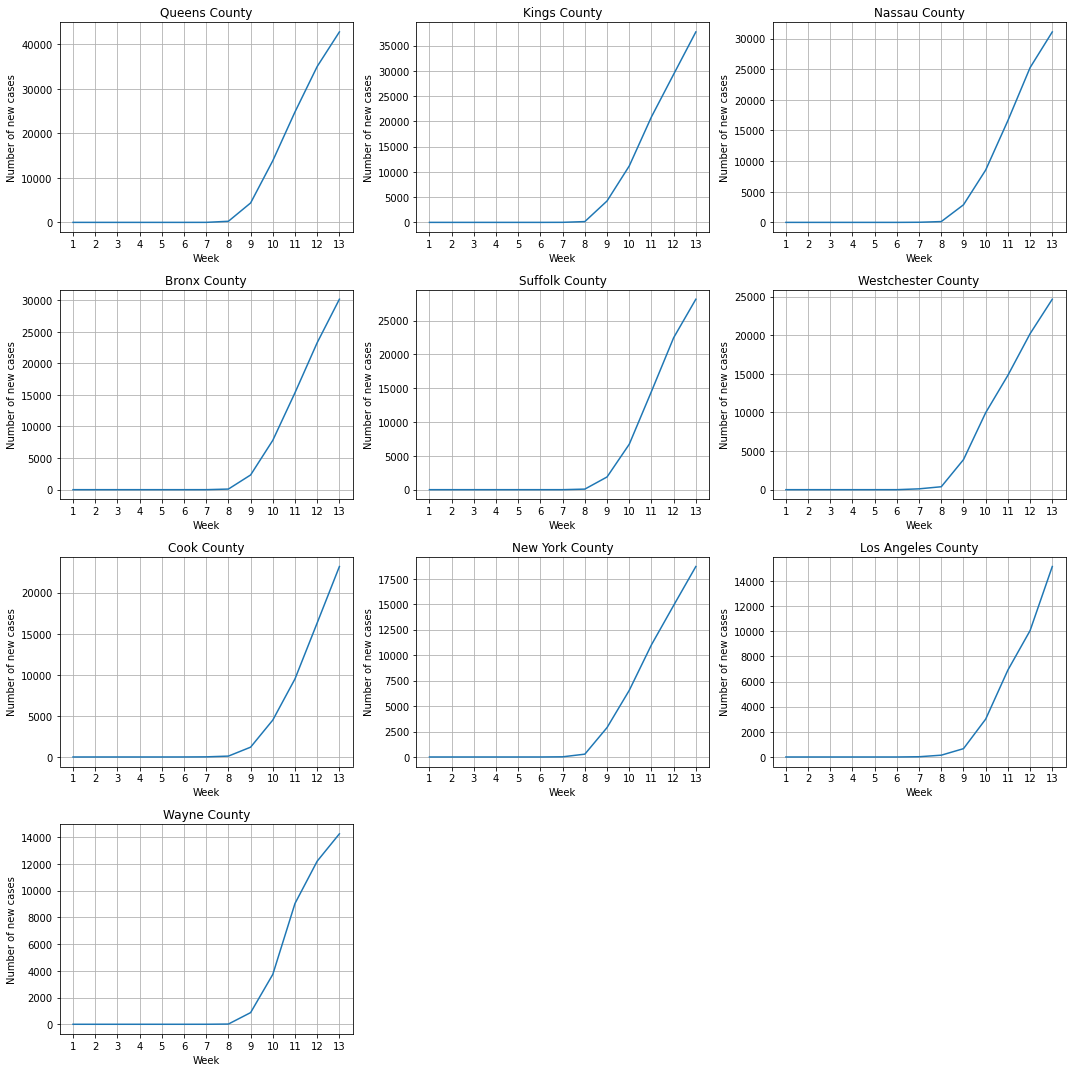

In [105]:
fig=plt.figure(figsize=(15,15))
for county_with_most_known_cases in range(len(counties_with_most_known_cases)):
    out=cases_per_week_count(cases_per_day_count(counties_with_most_known_cases.iloc[county_with_most_known_cases],dates),dates)
    ax = fig.add_subplot(4,3,county_with_most_known_cases+1)
    ax.plot(out['Week'],out['NumberOfCases'])
    ax.set_title(counties_with_most_known_cases['County Name'][county_with_most_known_cases])
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of new cases')
    ax.grid()
    ax.set_xticks(range(1,14))
fig.tight_layout()
plt.show()

As we can clearly see that all the counties have similarity in terms of the growth in number of cases each week. It can be observed that almost all of them showed similar exponential increase in cases after 8th week. The difference between all the counties are number of cases increasing every week.

## Q6.Compute the number of known cases per population in each county that have cases of covid-19. Produce a bar graph and table of the results for the 10 counties with the highest values and the 10 counties with the lowest values

In [36]:
combined_df_population_confirmed_cases=usa_county_population[['County Name','population','State']]
combined_df_population_confirmed_cases['confirmed_cases']=covid_19_confirmed_cases['4/23/20']
combined_df_population_confirmed_cases

,County Name,population,State,confirmed_cases
0,Statewide Unallocated,0,AL,0
1,Autauga County,55869,AL,33
2,Baldwin County,223234,AL,143
3,Barbour County,24686,AL,30
4,Bibb County,22394,AL,33
...,...,...,...,...
3190,Sweetwater County,42343,WY,10
3191,Teton County,23464,WY,63
3192,Uinta County,20226,WY,6
3193,Washakie County,7805,WY,5


In [37]:
combined_df_population_confirmed_cases_filtered=combined_df_population_confirmed_cases[(combined_df_population_confirmed_cases['population']!=0) & (combined_df_population_confirmed_cases['confirmed_cases']!=0)]
combined_df_population_confirmed_cases_filtered.head()

,County Name,population,State,confirmed_cases
1,Autauga County,55869,AL,33
2,Baldwin County,223234,AL,143
3,Barbour County,24686,AL,30
4,Bibb County,22394,AL,33
5,Blount County,57826,AL,31


In [38]:
combined_df_population_confirmed_cases_filtered['cases_per_100000_people']=combined_df_population_confirmed_cases_filtered['confirmed_cases']/combined_df_population_confirmed_cases_filtered['population']*100000
combined_df_population_confirmed_cases_filtered=combined_df_population_confirmed_cases_filtered.sort_values(by='cases_per_100000_people',ascending=False).reset_index(drop=True)
combined_df_population_confirmed_cases_filtered.head()

,County Name,population,State,confirmed_cases,cases_per_100000_people
0,Lincoln County,13024,AR,630,4837.223587
1,Marion County,65093,OH,2161,3319.865423
2,Rockland County,325789,NY,9828,3016.676438
3,Pickaway County,58457,OH,1661,2841.404793
4,Westchester County,967506,NY,25959,2683.084136


In [39]:
counties_with_highest_cases_per_population_ratio=combined_df_population_confirmed_cases_filtered.head(10)
counties_with_highest_cases_per_population_ratio

,County Name,population,State,confirmed_cases,cases_per_100000_people
0,Lincoln County,13024,AR,630,4837.223587
1,Marion County,65093,OH,2161,3319.865423
2,Rockland County,325789,NY,9828,3016.676438
3,Pickaway County,58457,OH,1661,2841.404793
4,Westchester County,967506,NY,25959,2683.084136
5,Nassau County,1356924,NY,32124,2367.413356
6,Bledsoe County,15064,TN,351,2330.058417
7,Louisa County,11035,IA,251,2274.580879
8,Bronx County,1418207,NY,31659,2232.325747
9,Richmond County,476143,NY,10590,2224.121745


In [40]:
counties_with_lowest_cases_per_population_ratio=combined_df_population_confirmed_cases_filtered.tail(10).sort_values(by='cases_per_100000_people')
counties_with_lowest_cases_per_population_ratio

,County Name,population,State,confirmed_cases,cases_per_100000_people
2771,Tehama County,65084,CA,1,1.536476
2770,Phelps County,44573,MO,1,2.243511
2769,Warren County,39191,PA,1,2.551606
2768,Chippewa County,37349,MI,1,2.677448
2767,Wood County,72999,WI,2,2.739764
2766,Cowley County,34908,KS,1,2.864673
2765,Fulton County,34340,IL,1,2.912056
2764,Morrison County,33386,MN,1,2.995267
2763,Polk County,32149,MO,1,3.110517
2762,Trempealeau County,29649,WI,1,3.372795


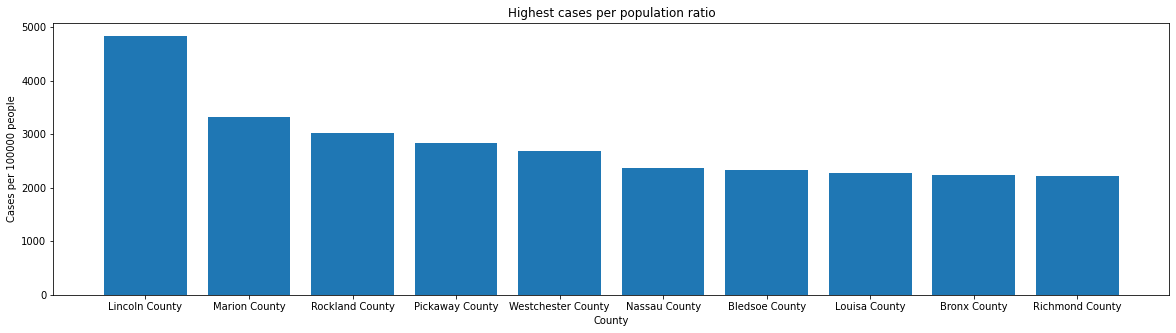

In [41]:
plt.figure(figsize=(20,5))
plt.bar(counties_with_highest_cases_per_population_ratio['County Name'],counties_with_highest_cases_per_population_ratio['cases_per_100000_people'])
plt.title('Highest cases per population ratio')
plt.xlabel('County')
plt.ylabel('Cases per 100000 people')
plt.show()

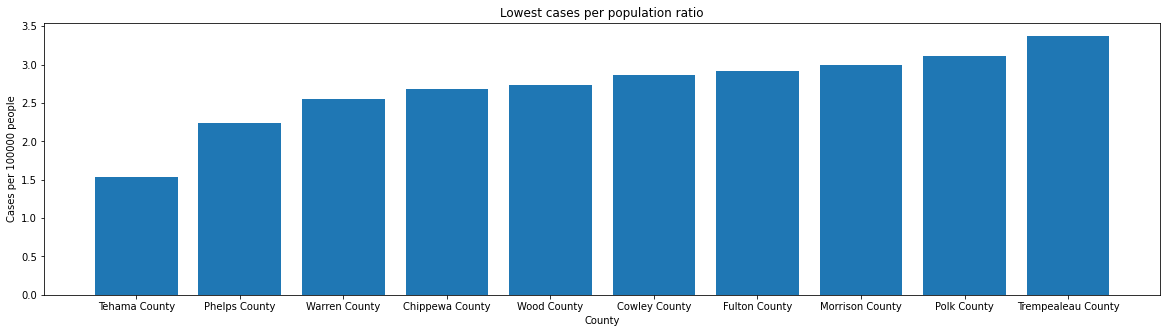

In [42]:
plt.figure(figsize=(20,5))
plt.bar(counties_with_lowest_cases_per_population_ratio['County Name'],counties_with_lowest_cases_per_population_ratio['cases_per_100000_people'])
plt.title('Lowest cases per population ratio')
plt.xlabel('County')
plt.ylabel('Cases per 100000 people')
plt.show()

## 7. Compute the death rate (deaths/ known cases) in each county that have both deaths and known cases. Compute the mean and standard deviation of the results. 

In [43]:
combined_df_death_and_confirmed_cases=covid_19_deaths[['County Name', 'State']]
combined_df_death_and_confirmed_cases['deaths']=covid_19_deaths['4/23/20']
combined_df_death_and_confirmed_cases['confirmed_cases']=covid_19_confirmed_cases['4/23/20']

In [44]:
combined_df_death_and_confirmed_cases_filtered=combined_df_death_and_confirmed_cases[(combined_df_death_and_confirmed_cases['deaths']>0) & (combined_df_death_and_confirmed_cases['confirmed_cases']>0)].reset_index(drop=True)
combined_df_death_and_confirmed_cases_filtered.head()

,County Name,State,deaths,confirmed_cases
0,Autauga County,AL,2,33
1,Baldwin County,AL,3,143
2,Calhoun County,AL,3,88
3,Chambers County,AL,16,275
4,Chilton County,AL,1,47


In [45]:
combined_df_death_and_confirmed_cases_filtered['death_rate']=combined_df_death_and_confirmed_cases_filtered['deaths']/combined_df_death_and_confirmed_cases_filtered['confirmed_cases']
combined_df_death_and_confirmed_cases_filtered.head()

,County Name,State,deaths,confirmed_cases,death_rate
0,Autauga County,AL,2,33,0.060606
1,Baldwin County,AL,3,143,0.020979
2,Calhoun County,AL,3,88,0.034091
3,Chambers County,AL,16,275,0.058182
4,Chilton County,AL,1,47,0.021277


Since the question says that counties that have both death and known cases,I have only considered data with confirmed cases > 0 and deaths > 0

In [46]:
print('Mean of Death Rate',combined_df_death_and_confirmed_cases_filtered['death_rate'].mean())
print('Standard Deviation of Death Rate',combined_df_death_and_confirmed_cases_filtered['death_rate'].std())

Mean of Death Rate 0.07713615367229099
Standard Deviation of Death Rate 0.1433415482944992


## 8. Produce a violin plot of the death rates found in #7

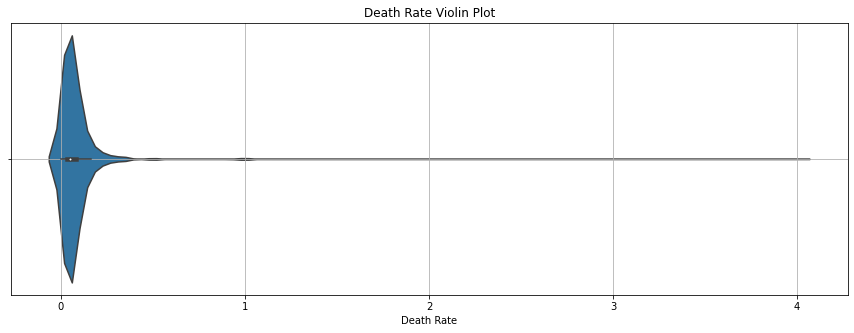

In [47]:
plt.figure(figsize=(15,5))
sns.violinplot(x=combined_df_death_and_confirmed_cases_filtered['death_rate'])
plt.xlabel('Death Rate')
plt.grid()
plt.title('Death Rate Violin Plot')
plt.show()

## 9. There is some hope that covid-19 may have peaked in NYC (counties Bronx, Kings, New York, Queens and Richmond). Is there any evidence of that in the data?

In [48]:
NYC_counties_data=covid_19_confirmed_cases[((covid_19_confirmed_cases['County Name']=='Queens County') | (covid_19_confirmed_cases['County Name']=='Kings County') | (covid_19_confirmed_cases['County Name']=='New York County') | (covid_19_confirmed_cases['County Name']=='Bronx County') | (covid_19_confirmed_cases['County Name']=='Richmond County')) & (covid_19_confirmed_cases['State']=='NY')]
NYC_counties_data=NYC_counties_data.reset_index(drop=True)
NYC_counties_data

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,36005,Bronx County,NY,36,0,0,0,0,0,0,...,23266,24653,25932,27035,28019,28823,29372,30142,31130,31659
1,36047,Kings County,NY,36,0,0,0,0,0,0,...,29306,31969,33521,34705,35763,36482,37030,37694,38481,39354
2,36061,New York County,NY,36,0,0,0,0,0,0,...,14880,16617,17091,17490,17932,18220,18468,18699,19025,19348
3,36081,Queens County,NY,36,0,0,0,0,0,0,...,35053,36765,37918,39091,40216,41237,42023,42822,43713,44904
4,36085,Richmond County,NY,36,0,0,0,0,0,0,...,7960,8298,8684,9031,9333,9674,9913,10166,10405,10590


In [49]:
NYC_counties_cases_per_day=cases_per_day_count(NYC_counties_data,dates)
NYC_counties_new_cases_per_day=new_cases_per_day_count(NYC_counties_cases_per_day)
NYC_counties_new_cases_per_day

,Day,NumberOfNewCases
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
88,89,3173
89,90,2370
90,91,2717
91,92,3231


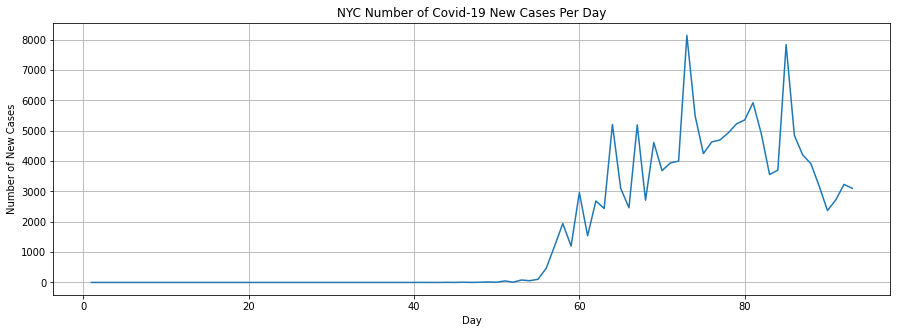

In [50]:
plt.figure(figsize=(15,5))
plt.plot(NYC_counties_new_cases_per_day['Day'],(NYC_counties_new_cases_per_day['NumberOfNewCases']))
plt.title('NYC Number of Covid-19 New Cases Per Day')
plt.xlabel('Day')
plt.ylabel('Number of New Cases')
plt.grid()
plt.show()

As we can see in the graph, we can analize that new confirmed cases goes up and down infrequently. We can see that during the last week, it reached the peek of more than 8000 cases in a single day but the day after that, it dropped below 5000. Since, the new cases are increasing and decreasing inconsistently, we cannot say that it has peaked or not without having more data for NYC. 

## 10.Seattle (King county in Washington) also hopes that they have peaked. Is there any evidence of that in the data?

In [51]:
Seattle=covid_19_confirmed_cases[(covid_19_confirmed_cases['County Name']=='King County') & (covid_19_confirmed_cases['State']=='WA')]
Seattle

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
3019,53033,King County,WA,53,1,1,1,1,1,1,...,4612,4676,4796,4865,5024,5135,5259,5360,5427,5532


In [52]:
seattle_per_day_cases=cases_per_day_count(Seattle,dates)
seattle_new_cases_per_day=new_cases_per_day_count(seattle_per_day_cases)
seattle_new_cases_per_day

,Day,NumberOfNewCases
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
88,89,111
89,90,124
90,91,101
91,92,67


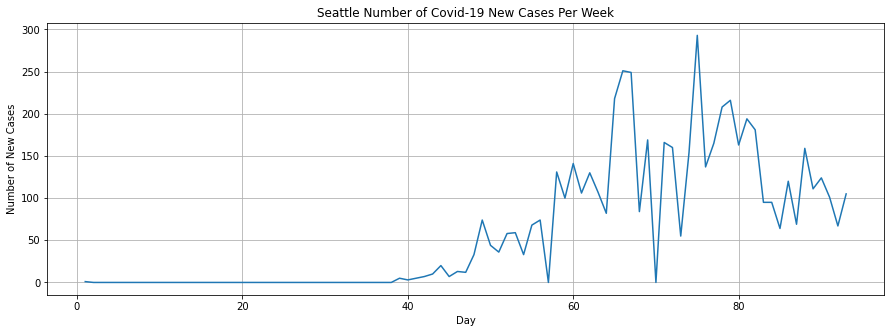

In [53]:
plt.figure(figsize=(15,5))
plt.plot(seattle_new_cases_per_day['Day'],seattle_new_cases_per_day['NumberOfNewCases'])
plt.title('Seattle Number of Covid-19 New Cases Per Week')
plt.xlabel('Day')
plt.ylabel('Number of New Cases')
plt.grid()
plt.show()

By looking at the graph, we can say that the growth of new covid-19 cases is fluctuating infrequently same as NYC. So, with this data we cannot clearly say that it has peaked in Seattle, we need more data to conclude that.